In [1]:
import pandas as pd
import numpy as np
import random
import requests
import torch
import torch.nn as nn
import torch_geometric
from torch_geometric.data import Data
from sklearn.cluster import KMeans
from geopy.distance import great_circle
import networkx as nx
import matplotlib.pyplot as plt

c:\Users\tejas\OneDrive\Desktop\major_project\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pandas as pd
import random
from geopy.distance import geodesic
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
import numpy as np

# Function to generate random customer data with additional features
def generate_random_customers(center_lat, center_lon, radius_km, num_customers):
    """Generate a DataFrame of random customer data within a certain radius."""
    
    def random_coordinates(center_lat, center_lon, radius_km):
        radius_in_degrees = radius_km / 111  # Approx. 111 km per degree latitude
        lat = center_lat + random.uniform(-radius_in_degrees, radius_in_degrees)
        lon = center_lon + random.uniform(-radius_in_degrees, radius_in_degrees)
        return lat, lon

    time_slots = ['9-11 AM', '10-12 AM', '1-3 PM', '2-4 PM', '4-6 PM']
    preferences = ['fast', 'standard', 'premium']
    
    customer_data = {
        'customer_id': [i for i in range(1, num_customers + 1)],
        'latitude': [],
        'longitude': [],
        'preferred_time_slot': [random.choice(time_slots) for _ in range(num_customers)],
        'demand_density': [random.randint(10, 100) for _ in range(num_customers)]  # Random demand density
    }

    for _ in range(num_customers):
        lat, lon = random_coordinates(center_lat, center_lon, radius_km)
        customer_data['latitude'].append(lat)
        customer_data['longitude'].append(lon)

    df = pd.DataFrame(customer_data)
    
    # Calculate distance to the central point for each customer
    def calculate_distance(lat1, lon1, lat2, lon2):
        return geodesic((lat1, lon1), (lat2, lon2)).km
    
    central_point = (center_lat, center_lon)
    df['distance_to_central_point'] = df.apply(
        lambda row: calculate_distance(row['latitude'], row['longitude'], central_point[0], central_point[1]),
        axis=1
    )

    return df
# Define center point and radius
center_latitude = 28.6139  # Example: New Delhi
center_longitude = 77.2090
radius_kilometers = 5  # Radius in kilometers
num_customers = 200

# Generate random customer data
customers_df = generate_random_customers(center_latitude, center_longitude, radius_kilometers, num_customers)
customers_df.head()

,customer_id,latitude,longitude,preferred_time_slot,demand_density,distance_to_central_point
0,1,28.576686,77.218865,4-6 PM,21,4.235764
1,2,28.645308,77.248425,10-12 AM,43,5.194146
2,3,28.617623,77.183928,2-4 PM,67,2.486439
3,4,28.618434,77.227720,2-4 PM,52,1.898437
4,5,28.636167,77.251947,4-6 PM,94,4.871108


In [3]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Cluster customers based on timeslots and geographic coordinates
def cluster_customers(customers_df, num_clusters=5):
    clusters = {}
    for time_slot in customers_df['preferred_time_slot'].unique():
        slot_customers = customers_df[customers_df['preferred_time_slot'] == time_slot]
        kmeans = KMeans(n_clusters=min(num_clusters, len(slot_customers)), random_state=0)
        slot_customers.loc[:, 'cluster'] = kmeans.fit_predict(slot_customers[['latitude', 'longitude','demand_density', 'distance_to_central_point']])

        clusters[time_slot] = slot_customers
    
    return clusters

# Cluster customers
clustered_customers = cluster_customers(customers_df)
for slot, df in clustered_customers.items():
    print(f"Time slot: {slot}, Clusters:\n{df.head()}")


Time slot: 4-6 PM, Clusters:
    customer_id   latitude  longitude preferred_time_slot  demand_density  \
0             1  28.576686  77.218865              4-6 PM              21   
4             5  28.636167  77.251947              4-6 PM              94   
13           14  28.658928  77.167271              4-6 PM              81   
15           16  28.620635  77.224328              4-6 PM              30   
16           17  28.604006  77.185456              4-6 PM              77   

    distance_to_central_point  cluster  
0                    4.235764        2  
4                    4.871108        1  
13                   6.446115        1  
15                   1.674558        4  
16                   2.550438        3  
Time slot: 10-12 AM, Clusters:
    customer_id   latitude  longitude preferred_time_slot  demand_density  \
1             2  28.645308  77.248425            10-12 AM              43   
6             7  28.644388  77.209301            10-12 AM              16   


C:\Users\tejas\AppData\Local\Temp\ipykernel_22356\4117956681.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slot_customers.loc[:, 'cluster'] = kmeans.fit_predict(slot_customers[['latitude', 'longitude','demand_density', 'distance_to_central_point']])
C:\Users\tejas\AppData\Local\Temp\ipykernel_22356\4117956681.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slot_customers.loc[:, 'cluster'] = kmeans.fit_predict(slot_customers[['latitude', 'longitude','demand_density', 'distance_to_central_point']]

In [15]:
from sklearn.metrics import silhouette_score
print("Silhouette Score for each cluster:")
for slot, df in clustered_customers.items():
    score = silhouette_score(df[['latitude', 'longitude','demand_density', 'distance_to_central_point']], df['cluster'])
    print(f"Time slot: {slot}, Silhouette Score: {score:.2f}")

Silhouette Score for each cluster:
Time slot: 4-6 PM, Silhouette Score: 0.54
Time slot: 10-12 AM, Silhouette Score: 0.55
Time slot: 2-4 PM, Silhouette Score: 0.64
Time slot: 1-3 PM, Silhouette Score: 0.62
Time slot: 9-11 AM, Silhouette Score: 0.53


In [4]:
# Assign delivery personnel to each cluster
def assign_delivery_personnel(clustered_customers):
    personnel_assigned = {}
    for time_slot, df in clustered_customers.items():
        df.loc[:,'delivery_personnel']= [f"Personnel_{cluster}" for cluster in df['cluster']]
        personnel_assigned[time_slot] = df
    return personnel_assigned

# Assign delivery personnel to clusters
clustered_customers_with_personnel = assign_delivery_personnel(clustered_customers)
print(clustered_customers_with_personnel['9-11 AM'].head(30))


     customer_id   latitude  longitude preferred_time_slot  demand_density  \
17            18  28.604141  77.201012             9-11 AM              70   
41            42  28.637938  77.252051             9-11 AM              26   
46            47  28.594787  77.211722             9-11 AM              20   
64            65  28.590936  77.182781             9-11 AM              67   
70            71  28.641499  77.176490             9-11 AM              53   
72            73  28.610217  77.253792             9-11 AM              72   
80            81  28.576655  77.164161             9-11 AM              89   
89            90  28.600307  77.175683             9-11 AM              38   
91            92  28.608342  77.180767             9-11 AM              54   
97            98  28.605575  77.209440             9-11 AM              79   
99           100  28.570890  77.166395             9-11 AM              25   
108          109  28.658549  77.208332             9-11 AM      

C:\Users\tejas\AppData\Local\Temp\ipykernel_22356\2519619534.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'delivery_personnel']= [f"Personnel_{cluster}" for cluster in df['cluster']]
C:\Users\tejas\AppData\Local\Temp\ipykernel_22356\2519619534.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'delivery_personnel']= [f"Personnel_{cluster}" for cluster in df['cluster']]
C:\Users\tejas\AppData\Local\Temp\ipykernel_22356\2519619534.py:5: SettingWithCopyWarning: 
A value is trying to b

In [5]:
import networkx as nx
import requests

HERE_API_KEY = 'Ur5mcEt5nP9kQNySgZFeILZ6HyxBJmJOMHabtjorKVQ'

def get_distance_data(origin, destination):
    url = f"https://router.hereapi.com/v8/routes?transportMode=car&origin={origin}&destination={destination}&return=summary&apiKey={HERE_API_KEY}"
    try:
        response = requests.get(url)
        response.raise_for_status()
        return response.json()
    except Exception as e:
        print(f"Error: {e}")
        return None

# Create a graph for a chosen cluster
def create_graph_for_cluster(df):
    G = nx.Graph()
    for index, row in df.iterrows():
        G.add_node(f"Customer {row['customer_id']}", pos=(row['latitude'], row['longitude']))
    
    # Limit API calls to 150
    api_call_count = 0
    api_call_limit = 150
    
    for index_a, row_a in df.iterrows():
        for index_b, row_b in df.iterrows():
            if index_a != index_b and api_call_count < api_call_limit:
                origin = f"{row_a['latitude']},{row_a['longitude']}"
                destination = f"{row_b['latitude']},{row_b['longitude']}"
                travel_data = get_distance_data(origin, destination)
                
                if travel_data and 'routes' in travel_data and travel_data['routes']:
                    distance = travel_data['routes'][0]['sections'][0]['summary']['length'] / 1000
                    G.add_edge(f"Customer {row_a['customer_id']}", f"Customer {row_b['customer_id']}", weight=distance)
                    api_call_count += 1
    
    return G

# Choose a cluster (e.g., from the '9-11 AM' timeslot)
chosen_cluster = clustered_customers_with_personnel['9-11 AM'][clustered_customers_with_personnel['9-11 AM']['cluster'] == 0]
G = create_graph_for_cluster(chosen_cluster)


In [6]:
print(G.nodes())

['Customer 71', 'Customer 92', 'Customer 125', 'Customer 126', 'Customer 140', 'Customer 169', 'Customer 192']


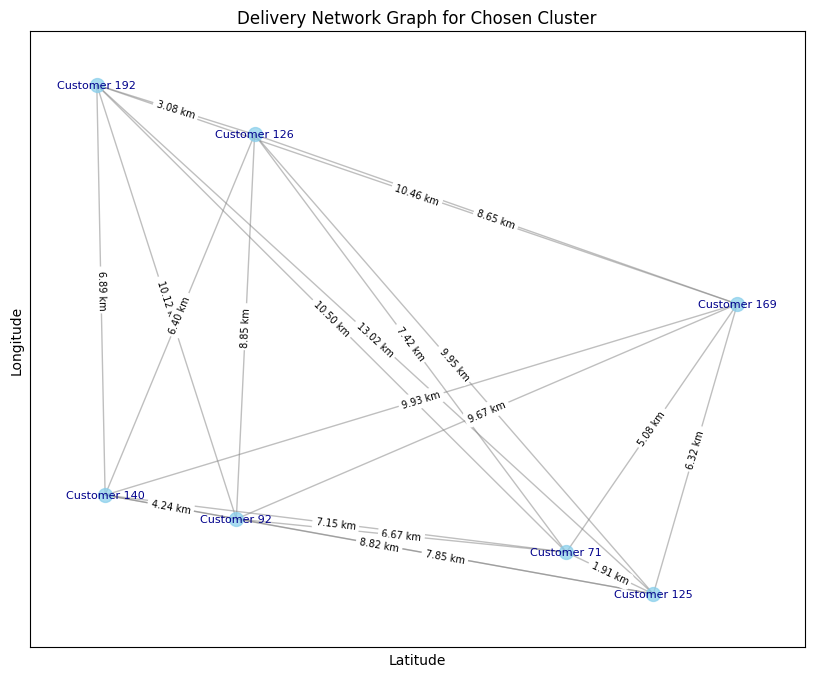

In [8]:
import matplotlib.pyplot as plt
import networkx as nx

# Function to visualize the graph
def visualize_graph(G):
    """Visualize the delivery network graph."""
    # Get positions of nodes for plotting
    pos = nx.get_node_attributes(G, 'pos')
    
    # Draw nodes and edges
    plt.figure(figsize=(10, 8))
    nx.draw_networkx_nodes(G, pos, node_size=100, node_color='skyblue', alpha=0.7)
    nx.draw_networkx_edges(G, pos, width=1, alpha=0.5, edge_color='gray')
    nx.draw_networkx_labels(G, pos, font_size=8, font_color="darkblue")
    
    # Display edge weights (distances in km)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f"{d:.2f} km" for u, v, d in G.edges(data='weight')}, font_size=7)
    
    # Display the plot
    plt.title("Delivery Network Graph for Chosen Cluster")
    plt.xlabel("Latitude")
    plt.ylabel("Longitude")
    plt.show()

# Select a cluster (e.g., from the '9-11 AM' time slot)
chosen_cluster = clustered_customers_with_personnel['9-11 AM'][clustered_customers_with_personnel['9-11 AM']['cluster'] == 0]

# Create the graph for the chosen cluster
G = create_graph_for_cluster(chosen_cluster)

# Visualize the graph
visualize_graph(G)


In [9]:
# Step 5: Create and train the GNN model
class GNN(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super(GNN, self).__init__()
        self.conv1 = torch_geometric.nn.GCNConv(in_channels, hidden_channels)
        self.conv2 = torch_geometric.nn.GCNConv(hidden_channels, hidden_channels)

    def forward(self, x, edge_index, edge_weight=None):
        x = self.conv1(x, edge_index, edge_weight)
        x = torch.relu(x)
        x = self.conv2(x, edge_index, edge_weight)
        return x


In [10]:
def create_graph_data(G):
    node_indices = {node: idx for idx, node in enumerate(G.nodes)}
    edge_index = []
    edge_attr = []

    for u, v, data in G.edges(data=True):
        edge_index.append([node_indices[u], node_indices[v]])
        edge_attr.append(data['weight'])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr, dtype=torch.float).view(-1, 1)

    num_nodes = len(G.nodes)
    x = torch.ones((num_nodes, 1))  # Dummy node features

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr), node_indices

graph_data, node_indices = create_graph_data(G)


In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN(in_channels=1, hidden_channels=16).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
graph_data = graph_data.to(device)

model.train()
for epoch in range(100):
    optimizer.zero_grad()
    out = model(graph_data.x, graph_data.edge_index, graph_data.edge_attr)
    loss = torch.mean(out)  # Simplified loss for demonstration
    loss.backward()
    optimizer.step()

print("Training completed.")

Training completed.


In [12]:
# Use the model to predict optimal routes
model.eval()
with torch.no_grad():
    predictions = model(graph_data.x.to(device), graph_data.edge_index.to(device))

# Define your routing logic based on predictions
print("Predictions:", predictions)


Predictions: tensor([[-28.7562, -28.0477, -28.8410, -30.7310, -29.2806, -31.5064, -32.2160,
         -32.3371, -26.3040, -30.1700, -25.1780, -27.2240, -27.1398, -31.2697,
         -33.0072, -31.5176],
        [-36.1176, -35.2226, -36.2273, -38.6175, -36.7861, -39.5959, -40.5024,
         -40.6530, -33.0167, -37.9096, -31.5932, -34.1796, -34.0724, -39.2983,
         -41.4950, -39.6129],
        [-40.5812, -39.5736, -40.7066, -43.3999, -41.3383, -44.5008, -45.5289,
         -45.6967, -37.0875, -42.6035, -35.4838, -38.3974, -38.2760, -44.1666,
         -46.6415, -44.5219],
        [-43.7447, -42.6573, -43.8814, -46.7894, -44.5651, -47.9767, -49.0919,
         -49.2716, -39.9726, -45.9303, -38.2414, -41.3866, -41.2551, -47.6169,
         -50.2887, -48.0012],
        [-46.1702, -45.0217, -46.3158, -49.3883, -47.0394, -50.6418, -51.8243,
         -52.0129, -42.1849, -48.4814, -40.3559, -43.6785, -43.5393, -50.2624,
         -53.0852, -50.6689],
        [-48.1222, -46.9246, -48.2749, -51.4799

In [13]:
# Step 6: Predict the optimal path using the GNN
model.eval()
with torch.no_grad():
    predictions = model(graph_data.x, graph_data.edge_index, graph_data.edge_attr)
    # Get the predicted order of nodes based on the output of the model
    predicted_node_indices = predictions.squeeze().tolist()  # Convert to list
    sorted_indices = sorted(range(len(predicted_node_indices)), key=lambda x: predicted_node_indices[x])

    # Create the optimal path using the sorted indices
    optimal_path = [list(node_indices.keys())[i] for i in sorted_indices]

# Print the optimal path to verify
print("Optimal Path:", optimal_path)


Optimal Path: ['Customer 192', 'Customer 126', 'Customer 169', 'Customer 140', 'Customer 92', 'Customer 125', 'Customer 71']


In [14]:
import folium

def visualize_route(customers, optimal_path):
    """Visualize the optimal path on a map using Folium."""
    m = folium.Map(location=[customers['latitude'].mean(), customers['longitude'].mean()], zoom_start=13)

    # Add markers for customers
    for _, customer in customers.iterrows():
        folium.Marker([customer['latitude'], customer['longitude']], tooltip=f"Customer {customer['customer_id']}").add_to(m)

    # Prepare path coordinates
    path_coords = []
    for id in optimal_path:
        # Extract the customer ID from the optimal path
        customer_id = int(id.split()[1])  # Assuming id is formatted as 'Customer 1'
        
        # Locate customer coordinates in the DataFrame
        customer_row = customers[customers['customer_id'] == customer_id]
        
        if not customer_row.empty:  # Check if customer exists
            path_coords.append((customer_row.iloc[0]['latitude'], customer_row.iloc[0]['longitude']))
        else:
            print(f"Customer ID {customer_id} not found in customer DataFrame.")

    # Check if path_coords is not empty and visualize
    if path_coords:
        folium.PolyLine(locations=path_coords, color='blue').add_to(m)
        print("Optimal path coordinates:", path_coords)
    else:
        print("No valid coordinates found for the optimal path.")

    return m

# Sample usage: Assuming optimal_path is already defined and contains valid customer IDs
if 'optimal_path' in locals():
    print("Optimal Path:", optimal_path)  # Debugging output
    route_map = visualize_route(customers_df, optimal_path)
    route_map.save('optimal_route_map.html')
    print("Map saved as 'optimal_route_map.html'.")
else:
    print("Optimal path is not defined.")


Optimal Path: ['Customer 192', 'Customer 126', 'Customer 169', 'Customer 140', 'Customer 92', 'Customer 125', 'Customer 71']
Optimal path coordinates: [(28.594325343298387, 77.23653721377102), (28.61017912951205, 77.23017046448189), (28.65867200452146, 77.2083854971295), (28.595160622273884, 77.1838413448505), (28.60834208592356, 77.18076720433685), (28.650237715394525, 77.17112672278162), (28.64149941533891, 77.17649029415641)]
Map saved as 'optimal_route_map.html'.
